## SVD/PCA/NMF and choosing the best k (reduced feature dimension)

In [1]:
import os
import sys
parent_dr = os.path.split(os.getcwd())[0]
if parent_dr not in sys.path:
    sys.path.append(parent_dr)

In [2]:
%load_ext autoreload
%autoreload 2

import scipy.sparse as sp
import scipy.linalg as sla
import pandas as pd
from sklearn.decomposition import NMF, TruncatedSVD
import numpy.linalg as la
import matplotlib . pyplot as plt # plots
from time import time
from core.data.arxiv_data_io import *
from core.data.text.tf_idf_helpers import *
from core.matrix.svd_decomposition_helpers import *

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
#reading in the full arXiv subset df
file_name = "tokenized_arxiv_subset_15540.pkl"
full_path = os.path.join(parent_dr, "core", "resources", file_name)
data_df = pd.read_pickle(full_path)

In [5]:
data_df.head(n=2)

,id,authors,title,categories,abstract,update_dt,clean,tokens
0,0704.0648,Kaushik Majumdar,Behavioral response to strong aversive stimuli: A neurodynamical model,q-bio.NC,"In this paper a theoretical model of functioning of a neural circuit during a\nbehavioral response has been proposed. A neural circuit can be thought of as a\ndirected multigraph whose each vertex is a neuron and each edge is a synapse.\nIt has been assumed in this paper that the behavior of such circuits is\nmanifested through the collective behavior of neurons belonging to that\ncircuit. Behavioral information of each neuron is contained in the coefficients\nof the fast Fourier transform (FFT) over the output spike train. Those\ncoefficients form a vector in a multidimensional vector space. Behavioral\ndynamics of a neuronal network in response to strong aversive stimuli has been\nstudied in a vector space in which a suitable pseudometric has been defined.\nThe neurodynamical model of network behavior has been formulated in terms of\nexisting memory, synaptic plasticity and feelings. The model has an analogy in\nclassical electrostatics, by which the notion of force and potential energy has\nbeen introduced. Since the model takes input from each neuron in a network and\nproduces a behavior as the output, it would be extremely difficult or may even\nbe impossible to implement. But with the help of the model a possible\nexplanation for an hitherto unexplained neurological observation in human brain\nhas been offered. The model is compatible with a recent model of sequential\nbehavioral dynamics. The model is based on electrophysiology, but its relevance\nto hemodynamics has been outlined.\n",2007-05-23,in this paper a theoretical model of functioning of a neural circuit during a behavioral response has been proposed a neural circuit can be thought of as a directed multigraph whose each vertex is a neuron and each edge is a synapse it has been assumed in this paper that the behavior of such circuits is manifested through the collective behavior of neurons belonging to that circuit behavioral information of each neuron is contained in the coefficients of the fast fourier transform fft over the output spike train those coefficients form a vector in a multidimensional vector space behavioral dynamics of a neuronal network in response to strong aversive stimuli has been studied in a vector space in which a suitable pseudometric has been defined the neurodynamical model of network behavior has been formulated in terms of existing memory synaptic plasticity and feelings the model has an analogy in classical electrostatics by which the notion of force and potential energy has been introduced since the model takes input from each neuron in a network and produces a behavior as the output it would be extremely difficult or may even be impossible to implement but with the help of the model a possible explanation for an hitherto unexplained neurological observation in human brain has been offered the model is compatible with a recent model of sequential behavioral dynamics the model is based on electrophysiology but its relevance to hemodynamics has been outlined,"[paper, theoretical, model, functioning, neural, circuit, behavioral, response, propose, neural, circuit, think, direct, multigraph, vertex, neuron, edge, synapse, assume, paper, behavior, circuit, manifest, collective, behavior, neuron, belong, circuit, behavioral, information, neuron, contain, coefficient, fast, fourier, transform, fft, output, spike, train, coefficient, form, vector, multidimensional, vector, space, behavioral, dynamic, neuronal, network, response, strong, aversive, stimulus, study, vector, space, suitable, pseudometric, define, neurodynamical, model, network, behavior, formulate, term, exist, memory, synaptic, plasticity, feeling, model, analogy, classical, electrostatic, notion, force, potential, energy, introduce, model, take, input, neuron, network, produce, behavior, output, extremely, d

In [6]:
# splitting out the test and train dfs
train_df, test_df = sample_arxiv_data_by_category(data_df)
assert len(train_df)/len(data_df) == 0.8

In [7]:
print(f'The training df has dimensions {train_df.shape}')
print(f'The testing df has dimensions {test_df.shape}')

The training df has dimensions (12432, 9)
The testing df has dimensions (3108, 9)


### Compute TF-IDF Matrix

In [8]:
# fit the tfidf object
train_tokens = train_df['tokens']
tfidf_obj, index_to_word = fit_tfidf(train_df['tokens'])

In [9]:
print(f'tfidf_obj is a {type(tfidf_obj)} \n with a vocabulary of {len(index_to_word)} words')

tfidf_obj is a <class 'sklearn.feature_extraction.text.TfidfVectorizer'> 
 with a vocabulary of 30460 words


In [10]:
# generate the tfidf matrix for the training data
tfidf_train_matrix, index_to_doc = transform_tfidf(train_df,tfidf_obj=tfidf_obj)

In [11]:
print(f'The TF-IDF matrix is a sparse matrix with dimensions: {tfidf_train_matrix.shape}')

The TF-IDF matrix is a sparse matrix with dimensions: (12432, 30460)


### NMF Decomposition

In [134]:
n_samples, n_features = tfidf_train_matrix.shape
k = 100

In [135]:
#this takes about a minute
t0 = time()
print("Fitting the NMF model with n_samples=%d and n_features=%d, and n_components=%d..."
      % (n_samples, n_features, k))

nmf_model = NMF(n_components = k, init='nndsvd', max_iter=1000,random_state=1)
W = nmf_model.fit_transform(tfidf_train_matrix)
H = nmf_model.components_
print("done in %0.3fs." % (time() - t0))

Fitting the NMF model with n_samples=12432 and n_features=30460, and n_components=100...
done in 60.477s.


In [136]:
print(f'W with dimensions: {W.shape} \n H with dimensions:{H.shape}')

W with dimensions: (12432, 100) 
 H with dimensions:(100, 30460)


In [137]:
#info about the decomposition
print(f'Number of components: {nmf_model.n_components}')
print(f'Reconstruction error:{nmf_model.reconstruction_err_}')
print(f'Number of iterations to train:{nmf_model.n_iter_}')
print(f'Number of features seen during fit:{nmf_model.n_features_in_}')

Number of components: 100
Reconstruction error:101.3534406269884
Number of iterations to train:113
Number of features seen during fit:30460


In [138]:
def nmf_k_search(input_matrix, k_vals):
    """
    function for searching over different values of k
    """
    
    results = []
    for kval in k_vals:
        print(f"Now fitting NMF for k ={kval}...")
        
        t0=time()
        nmf_model = NMF(n_components=kval, init='nndsvd',
                        max_iter=1000,random_state=1)
        W = nmf_model.fit_transform(input_matrix)
        time_elapsed = time() - t0
        H = nmf_model.components_
        
        entry = [kval, nmf_model.reconstruction_err_,
                 nmf_model.n_iter_, time_elapsed]
        
        print(entry)
        
        results.append(entry)
        
    results_df = pd.DataFrame(results, columns=['k', 'Reconstruction Error',
                                                'Iterations to convergence',
                                                'Time to converge (secs)'])
    
    return results_df

In [140]:
kvals_simple = list(range(1,100,10))
simple_results = nmf_k_search(tfidf_train_matrix, kvals_simple)
simple_results

Now fitting NMF for k =1...
[1, 110.14452881562842, 7, 0.15182805061340332]
Now fitting NMF for k =11...
[11, 107.91344005912548, 84, 1.1098711490631104]
Now fitting NMF for k =21...
[21, 106.65444060143894, 102, 2.506765842437744]
Now fitting NMF for k =31...
[31, 105.64561412128835, 216, 8.974475145339966]
Now fitting NMF for k =41...
[41, 104.85066663282167, 191, 13.959019899368286]
Now fitting NMF for k =51...
[51, 104.13117787951383, 274, 28.245112895965576]
Now fitting NMF for k =61...
[61, 103.48323030595336, 117, 19.09428596496582]
Now fitting NMF for k =71...
[71, 102.8995530403503, 173, 45.9632830619812]
Now fitting NMF for k =81...
[81, 102.35225469096571, 192, 66.89673590660095]
Now fitting NMF for k =91...
[91, 101.82173660291447, 273, 124.3284239768982]


,k,Reconstruction Error,Iterations to convergence,Time to converge (secs)
0,1,110.144529,7,0.151828
1,11,107.913440,84,1.109871
2,21,106.654441,102,2.506766
3,31,105.645614,216,8.974475
4,41,104.850667,191,13.959020
5,51,104.131178,274,28.245113
6,61,103.483230,117,19.094286
7,71,102.899553,173,45.963283
8,81,102.352255,192,66.896736
9,91,101.821737,273,124.328424


In [141]:
larger_k_vals = [150, 200, 300, 600, 1000, 15000]
larger_k_results = nmf_k_search(tfidf_train_matrix, larger_k_vals)
larger_k_results

Now fitting NMF for k =150...


KeyboardInterrupt: 

In [142]:
larger_results = [[150, 99.06062880181726, 243, 277.3060259819031],
                 [200, 97.01359152285178, 305, 625.0525093078613],
                 [300, 93.5664692723195, 236, 2153.6644287109375],
                 [600, 85.76961768114077, 119, 1938.1206359863281],
                 [1000, 77.81929157478947, 105, 4577.196753978729]]


larger_results_df = pd.DataFrame(larger_results, columns=['k', 'Reconstruction Error',
                                                'Iterations to convergence',
                                                'Time to converge (secs)'])
full_results_df = simple_results.append(larger_results_df)
full_results_df

,k,Reconstruction Error,Iterations to convergence,Time to converge (secs)
0,1,110.144529,7,0.151828
1,11,107.913440,84,1.109871
2,21,106.654441,102,2.506766
3,31,105.645614,216,8.974475
4,41,104.850667,191,13.959020
5,51,104.131178,274,28.245113
6,61,103.483230,117,19.094286
7,71,102.899553,173,45.963283
8,81,102.352255,192,66.896736
9,91,101.821737,273,124.328424


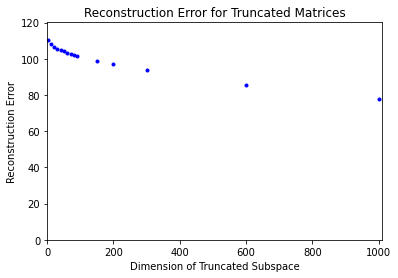

In [143]:
fig1 = plt.figure(23)
ax1 = plt.subplot(111)
ax1.plot(
    full_results_df.iloc[:,0], full_results_df.iloc[:,1], 'b.')
ax1.set_title('Reconstruction Error for Truncated Matrices')
ax1.set_xlabel('Dimension of Truncated Subspace')
ax1.set_ylabel('Reconstruction Error')
ax1.axis([0, 1010 , 0, max(full_results_df.iloc[:,1]) + 10])
plt.show()

### SVD

In [12]:
# TruncatedSVD code example
trunc_svd = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=5, random_state=1)
U = trunc_svd.fit_transform(tfidf_train_matrix)
V_T = trunc_svd.components_
sigmas = trunc_svd.singular_values_

print(f'U has dimensions: {U.shape}')
print(f'V_T has dimensions:{V_T.shape}')
print(f'Number of singluar values:{len(sigmas)}')

print(trunc_svd.explained_variance_)
print(trunc_svd.explained_variance_ratio_)

U has dimensions: (12432, 5)
V_T has dimensions:(5, 30460)
Number of singluar values:5
[0.00238821 0.00654541 0.00566692 0.00524155 0.00431598]
[0.00244164 0.00669185 0.0057937  0.00535882 0.00441254]


In [63]:
#alternative scipy sparse svd method
U_sp, sigmas_sp, V_T_sp = sp.linalg.svds(tfidf_train_matrix,
                                         k=1000, which='LM', maxiter=20)

print(f'U has dimensions: {U_sp.shape}')
print(f'V_T has dimensions:{V_T_sp.shape}')
print(f'Number of singluar values:{len(sigmas_sp)}')

U has dimensions: (12432, 1000)
V_T has dimensions:(1000, 30460)
Number of singluar values:1000


In [28]:
# Reconstruction error for scikit TruncatedSVD method
# this code demonstrates that we don't need to convert the sparse matrix
# to a dense matrix to find the reconstruction error
reconstruc = U @ np.diag(sigmas) @ V_T
diff_unadj = tfidf_train_matrix - reconstruc
dense_tfidf = tfidf_train_matrix.toarray()
diff_to_dense = dense_tfidf - reconstruc
unadj = la.norm(diff_unadj, ord='fro')
dense = la.norm(diff_to_dense, ord='fro')
print(f'unadjusted: {unadj} \n dense: {dense}')

unadjusted: 311.93168939539225 
 dense: 311.93168939539225


In [60]:
type(tfidf_train_matrix - reconstruc)

numpy.matrix

In [65]:
def svd_k_search(input_matrix, k_vals):
    """
    function for searching over different values of k
    """
    
    results = []
    for kval in k_vals:
        print(f"Now fitting truncated SVD for k ={kval}...")
        
        t0=time()
        #trunc_svd = TruncatedSVD(n_components=kval, algorithm='randomized',
        #                         n_iter=20, random_state=1)
        
        U, sigmas, V_T = sp.linalg.svds(input_matrix, k=kval, which='LM')
        time_elapsed = time() - t0
        
        # U = trunc_svd.fit_transform(input_matrix)
        # V_T = trunc_svd.components_
        # sigmas = trunc_svd.singular_values_
        
        # print(f'U has dimensions: {U.shape}')
        # print(f'V_T has dimensions:{V_T.shape}')
        # print(f'Number of singluar values:{len(sigmas)}')
        
        t_prime = time()
        recon_matrix = U @ np.diag(sigmas) @ V_T
        reconstruction_err = la.norm(input_matrix - recon_matrix, ord='fro')
        recon_time = time() - t_prime
        
        entry = [kval, reconstruction_err, time_elapsed, recon_time]
        print(entry)
        results.append(entry)
        
    results_df = pd.DataFrame(results, columns=['k', 'Reconstruction Error',
                                                'Time to converge (secs)',
                                                'Time to compute reconstruction err'])
    
    return results_df

In [66]:
#svd_k_vals = larger_k_vals
svd_k_search(tfidf_train_matrix,[1,2,3,4,5,10, 15,35,70,100,150,300,500])

Now fitting truncated SVD for k =1...
[1, 110.14452881561618, 0.06408095359802246, 4.836601972579956]
Now fitting truncated SVD for k =2...
[2, 109.77423610044545, 0.06250905990600586, 2.6673479080200195]
Now fitting truncated SVD for k =3...
[3, 109.45102036800031, 0.08362412452697754, 2.8702948093414307]
Now fitting truncated SVD for k =4...
[4, 109.15283265475175, 0.0795598030090332, 2.8350830078125]
Now fitting truncated SVD for k =5...
[5, 108.90614901410868, 0.07708597183227539, 2.813563108444214]
Now fitting truncated SVD for k =10...
[10, 107.94607181258625, 0.12374615669250488, 2.8766908645629883]
Now fitting truncated SVD for k =15...
[15, 107.17989248752093, 0.15616297721862793, 3.2897369861602783]
Now fitting truncated SVD for k =35...
[35, 105.03796179224288, 0.2901010513305664, 2.682055950164795]
Now fitting truncated SVD for k =70...
[70, 102.47529485296124, 0.5776321887969971, 3.2944090366363525]
Now fitting truncated SVD for k =100...
[100, 100.71650128699613, 1.169378

,k,Reconstruction Error,Time to converge (secs),Time to compute reconstruction err
0,1,110.144529,0.064081,4.836602
1,2,109.774236,0.062509,2.667348
2,3,109.451020,0.083624,2.870295
3,4,109.152833,0.079560,2.835083
4,5,108.906149,0.077086,2.813563
5,10,107.946072,0.123746,2.876691
6,15,107.179892,0.156163,3.289737
7,35,105.037962,0.290101,2.682056
8,70,102.475295,0.577632,3.294409
9,100,100.716501,1.169378,3.505223


#### Computing the Full SVD
The internet said that scipy's svd implementation of SVD is faster than numpy's so using that

In [73]:
# Code for computing the full SVD of the sparse matrix

print("computing full SVD of the dense tfidf matrix...")
t0 = time()
U, sigmas_sp, V_T_sp = sp.linalg.svds(tfidf_train_matrix,k=12431,which='LM', maxiter=None)
time_elapsed = time() - t0
print(f"SVD complete in {time_elapsed} seconds")

computing full SVD of the dense tfidf matrix...
SVD complete in 2524.3472471237183 seconds


In [74]:
reconstruc_u = U_sp @ np.diag(sigmas_sp) @ V_T_sp
reconstruction_err_u = la.norm(tfidf_train_matrix - reconstruc_u, ord='fro')
reconstruction_err_u
#doubling of k corresponds to tripling of time
#500 ~ 15s
#1000 ~ 45s
#2000 ~ 135s
#4000 ~ 405s
#8000 ~ 1215s = 20mins
#16000 ~ 3645s = 60mins

1.5106316574324512e-12

### Serializing the full SVD matrices

Scipy sparse SVD returns the singular values and vectors in reverse order (smallest singular values first). So first need to reverse the order of everything
https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html

In [211]:
# function in core/matrix/svd_decomposition_helpers that fixes the order
U_full, sigmas_full, V_T_full = fix_scipy_svds(U_sp, sigmas_sp,V_T_sp)

In [212]:
print(f'U_full has dimensions: {U_full.shape}')
print(f'V_T_full has dimensions:{V_T_sp.shape}')
print(f'Number of singluar values:{len(sigmas_full)}')

U_full has dimensions: (12432, 12431)
V_T_full has dimensions:(12431, 30460)
Number of singluar values:12431


Now serialize these reordered matrices

In [213]:
#serialize full SVD

output_file_names = ["tfidf_train_full_svd_U.pkl",
                     "tfidf_train_full_svd_sigmas.pkl",
                      "tfidf_train_full_svd_V_T.pkl"]

serialize_SVD(U_full, sigmas_full, V_T_full, output_file_names)

In [15]:
def compute_size(input_array):
    size = input_array.size
    item_size = input_array.itemsize
    num_bytes = size * item_size
    num_mb = num_bytes / 1000000
    return num_mb

In [18]:
# checking the size of the V_T array
print(compute_size(V_T_full))

3029.18608


In [217]:
# load in the serialized df to make sure it matches original df
# I also do this within the serialize_svd() function--just double checking here
V_T_reloaded = np.load("output/tfidf_train_full_svd_V_T.pkl", allow_pickle=True)
np.array_equal(V_T_reloaded,V_T_full)

True

In [17]:
np.array_equal(sigmas_full,V_T_full)

True

### Finding the optimal k with now that we have the full SVD
First read in the full SVD matrice we found above

In [10]:
# Reading in the matrices we just serialized for reproducibility's sake

U_full = np.load("output/tfidf_train_full_svd_U.pkl", allow_pickle=True)
V_T_full = np.load("output/tfidf_train_full_svd_V_T.pkl", allow_pickle=True)
sigmas_full = np.load("output/tfidf_train_full_svd_V_T.pkl", allow_pickle=True)


print(f'U_full has dimensions: {U_full.shape}')
print(f'V_T_full has dimensions:{V_T_full.shape}')
print(f'Number of singluar values:{sigmas_full.shape}')

U_full has dimensions: (12432, 12431)
V_T_full has dimensions:(12431, 30460)
Number of singluar values:(12431, 30460)


In [9]:
compute_truncated_svd_recon_err(U_full, sigmas_full, V_T_full, 4)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [13]:
np.diag(sigmas_full).shape
sigmas_full.shape

(12431, 30460)

In [1]:
(sigmas_sp**2).sum()

NameError: name 'sigmas_sp' is not defined

In [187]:
sv_reordering = np.argsort(-sigmas_sp)
sv_reordering
sigmas_sp[sv_reordering].shape

(12431,)

In [189]:
U_full, sigmas_full, V_T_full = fix_scipy_svds(U_sp, sigmas_sp,V_T_sp)

In [190]:
sigmas_full.shape

(12431,)

In [191]:
print(sigmas_sp[-10:])
print(sigmas_full[:10])


[ 6.06905148  6.16579305  6.25977293  6.72099837  6.99913619  7.33427457
  8.07372176  8.41766308  9.02409643 17.32578345]
[17.32578345  9.02409643  8.41766308  8.07372176  7.33427457  6.99913619
  6.72099837  6.25977293  6.16579305  6.06905148]
